# Probability integral transform (PIT) Histogram

Get observation & forecast data

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2
from Energy.Models.Model4_population import model4_population
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3
from Energy.Models.Model5 import model5
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_sunhours import model4_sunhours
# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

In [3]:
df = get_energy_data()
df = prepare_data(df)

In [4]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

Use cross validate functions to get the data. Cannot import fun

In [20]:
from HelpFunctions.mix_models import mix_models_per_horizon


def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else:
            pred = mix_models_per_horizon(model['function'][0], model['function'][1], df_before)
               
        
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

In [6]:

models = [
    # {
    #     'name': 'baseline',
    #     'function': baseline
    # },
    {
        'name': 'model5',
        'function': model5
     }
]
evaluate_models(models, df_cval, last_x=10, weeks=True)

*********** Start the evaluation of Model model5 ***********
Iteration 0 of 10
Iteration 1 of 10


KeyboardInterrupt: 

In [ ]:
with open('./Model evaluations/big_evaluation.pkl', 'rb') as f:
    models = pickle.load(f)

In [23]:
import numpy as np


model_index = 0
results = []

for h in ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']:
    results.append(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == h])

# results36h = models[0]['evaluation'][models[0]['evaluation']['horizon'] == '36 hour']



# results = models[0]['evaluation']



## Create PIT Histogram

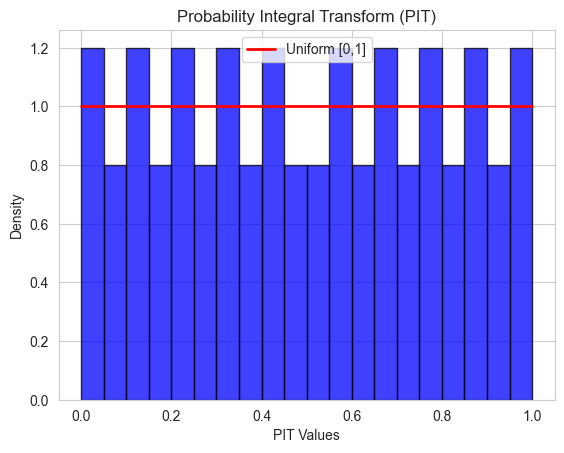

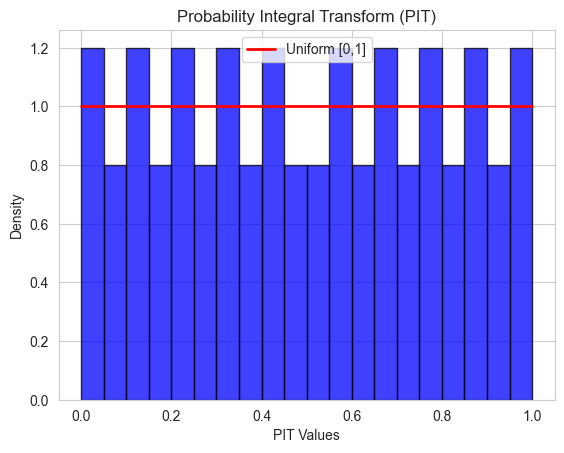

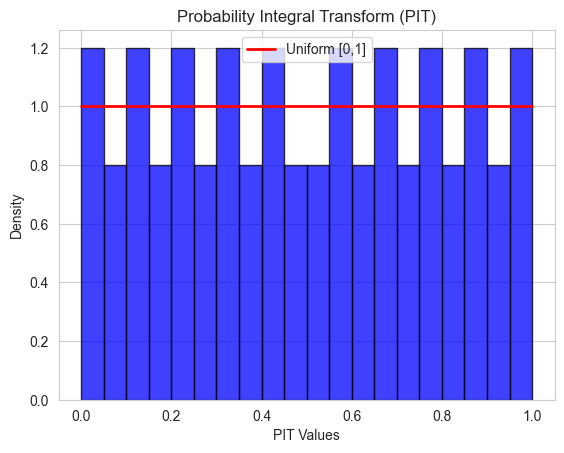

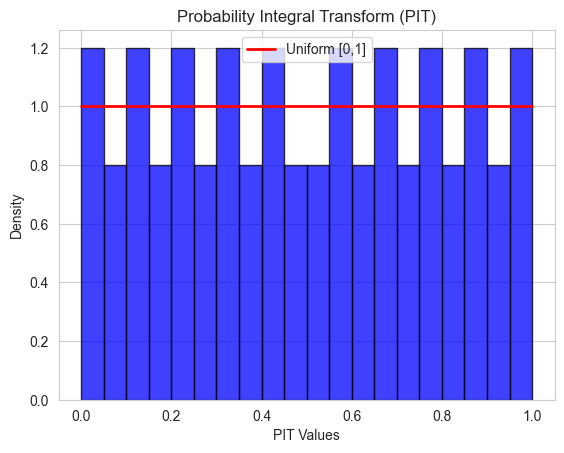

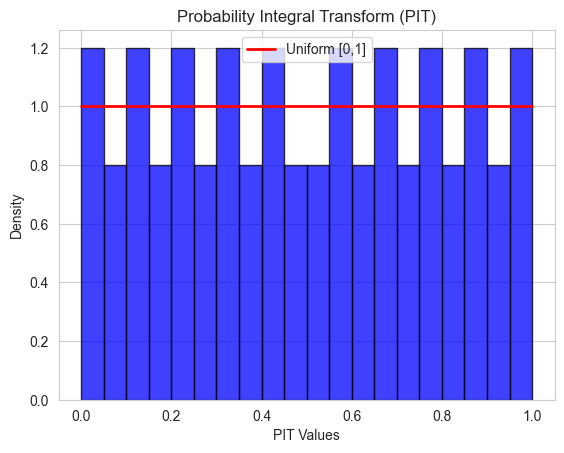

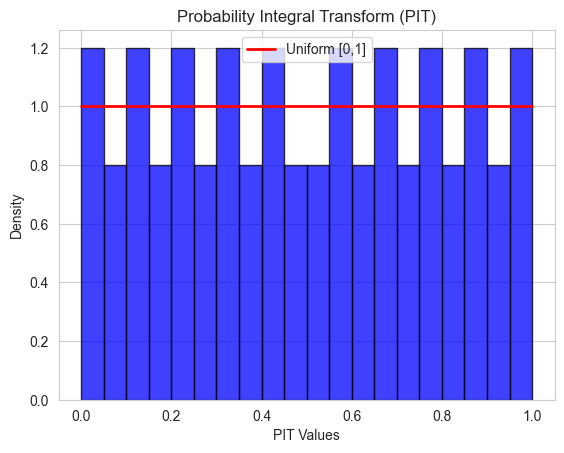

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import string
import random
import scipy.stats as stats

from scipy.stats import uniform

for index, r in enumerate(results):
    obs = np.array(np.array(r['gesamt']),dtype=float)
    forecasts = np.array(np.array(r.loc[:,'q0.025':'q0.975']),dtype=float)

    # Example quantile forecasts and observations
    quantile_forecasts = forecasts
    observations = obs
    
    # Calculate PIT values
    pit_values = np.zeros_like(quantile_forecasts)
    
    for i in range(quantile_forecasts.shape[1]):
        sorted_forecasts = np.sort(quantile_forecasts[:, i])
        ecdf_values = np.linspace(0, 1, len(sorted_forecasts))
        pit_values[:, i] = np.interp(
            quantile_forecasts[:, i], sorted_forecasts, ecdf_values)
    
    # Create PIT histogram
    fig, ax = plt.subplots()
    ax.hist(pit_values.flatten(), bins=20, density=True,
            alpha=0.75, color='blue', edgecolor='black')
    
    # Plot the uniform distribution for reference
    x = np.linspace(0, 1, 100)
    ax.plot(x, uniform.pdf(x), 'r-', lw=2, label='Uniform [0,1]')
    
    ax.set_title('Probability Integral Transform (PIT)')
    ax.set_xlabel('PIT Values')
    ax.set_ylabel('Density')
    ax.legend()
    
    
    plt.savefig(f'plots/{index} {"".join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(4))}.png')
    plt.show()

### Check Manually

In [25]:
array = []

for q in ['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']:
    # print(f'*** {q} ***')
    # arr = models[5]['evaluation'][q] > models[5]['evaluation']['gesamt']
    # print(arr.mean())
    
    per_quantile = []
    
    
    for index, r in enumerate(results):
        # r.loc[:, f'{q}larger'] = r[q] > r['gesamt']
        mean = (r[q] > r['gesamt']).mean()
        # print(r[f'{q}larger'].mean())
        per_quantile.append(round(mean,3))
    per_quantile.append(round((models[model_index]['evaluation'][q] > models[model_index]['evaluation']['gesamt']).mean(), 3))
    
    array.append(per_quantile)
        
pd.DataFrame(array, columns=['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour','All horizons'], index=['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975'])



,36 hour,40 hour,44 hour,60 hour,64 hour,68 hour,All horizons
q0.025,0.00,0.00,0.00,0.00,0.00,0.00,0.000
q0.25,0.02,0.14,0.02,0.00,0.14,0.00,0.053
q0.5,0.50,0.88,0.46,0.52,0.62,0.04,0.503
q0.75,0.94,0.98,0.92,0.88,0.94,0.30,0.827
q0.975,1.00,1.00,1.00,1.00,1.00,0.98,0.997


# Lets only use horizon data for training and check again

In [16]:
df_cval_horizon = df.loc[df.index < start_date_excl]
df_cval_horizon = df_cval_horizon[df_cval_horizon.index.dayofweek.isin([4,5])] # Only keep Friday & Saturday
df_cval_horizon = df_cval_horizon[df_cval_horizon.index.hour.isin([12,16,20])]
df_cval_horizon = df.loc[df.index < start_date_excl]


In [17]:
df_cval_horizon

,gesamt
date_time,
2018-12-24 00:00:00,42.02925
2018-12-24 01:00:00,39.61025
2018-12-24 02:00:00,39.13875
2018-12-24 03:00:00,39.42100
2018-12-24 04:00:00,40.74775
...,...
2023-12-27 19:00:00,54.01775
2023-12-27 20:00:00,51.45475
2023-12-27 21:00:00,49.84200


In [ ]:

models = [
    # {
    #     'name': 'baseline',
    #     'function': baseline
    # },
    {
        'name': 'model5',
        'function': model5
     }
]
evaluate_models(models, df_cval_horizon, last_x=150, weeks=True)

*********** Start the evaluation of Model model5 ***********
Iteration 0 of 150
Iteration 1 of 150
Iteration 2 of 150
Iteration 3 of 150
Iteration 4 of 150
Iteration 5 of 150
Iteration 6 of 150
Iteration 7 of 150
Iteration 8 of 150
Iteration 9 of 150
Iteration 10 of 150
Iteration 11 of 150
Iteration 12 of 150
Iteration 13 of 150


In [11]:
df_cval_horizon

,gesamt
date_time,
2018-12-28 12:00:00,58.90900
2018-12-28 16:00:00,58.55400
2018-12-28 20:00:00,55.58925
2018-12-29 12:00:00,56.84650
2018-12-29 16:00:00,57.72725
...,...
2023-12-22 16:00:00,59.91425
2023-12-22 20:00:00,55.81450
2023-12-23 12:00:00,55.88000


In [22]:
models[0]

{'name': 'model5',
 'function': <function Energy.Models.Model5.model5(energyconsumption, offset_horizons=0)>,
 'evaluation':                      target  horizon     q0.025      q0.25       q0.5  \
 forecast_date                                                           
 2023-12-22 12:00:00  energy  36 hour  50.531927  60.500656  66.023164   
 2023-12-22 16:00:00  energy  40 hour  50.075630  58.747889  63.694531   
 2023-12-22 20:00:00  energy  44 hour  47.672434  54.870631  58.825931   
 2023-12-23 12:00:00  energy  60 hour  41.371213  51.532535  56.168270   
 2023-12-23 16:00:00  energy  64 hour  40.914916  49.779768  53.839637   
 ...                     ...      ...        ...        ...        ...   
 2023-01-13 16:00:00  energy  40 hour  50.331735  59.360817  65.092132   
 2023-01-13 20:00:00  energy  44 hour  47.830483  55.553639  60.019768   
 2023-01-14 12:00:00  energy  60 hour  41.610042  52.172025  57.314139   
 2023-01-14 16:00:00  energy  64 hour  41.511680  50.454945  5